In [1]:
import sys
sys.path.append("/lus/cls01029/spartee/poseidon/smart-sim/")

# Improving MOM6 Simulations with Machine Learning using SmartSim
 - In this notebook we demonstrate how to run Modular Ocean Model 6 (MOM6) with our the machine learned EKE parameterization
 - We show how to use SmartSim to launch the machine learning infrastructure so that the Fortran-based MOM6 and a Pytorch Model can communicate during the simulation.
 - The Pytorch Model is trained on 1/10 degree MOM6 output data and queried by a 1/4 degree MOM6 simulation to provide the value of Eddy Kinetic Energy in each subdomain of the model every timestep (6 hours).

In [2]:
# import SmartSim and the Slurm interface for obtaining allocations.
from smartsim import Experiment, slurm
from smartsim.utils.log import log_to_file

In [3]:
# import some libraries for online data analysis
import os
import time
import numpy as np
import xarray as xr
from os import environ
import matplotlib.pyplot as plt

## 1.1) Create the SmartSim Experiment
 - The SmartSim library provides the Experiment object as the main API for the user.
 - The Experiment API is used for starting, monitoring, tracking, and stopping jobs created by the user.
 - Each experiment has a specific "launcher" which communicates with the WLM of the host machine to launch jobs.
    - Launcher options
       - PBS
       - Slurm
       - Local
       - Kubernetes (soon)
       - Capsules (soon)

In [4]:
# Create the SmartSim Experiment. 
experiment = Experiment("AI-EKE-MOM6", launcher="slurm")

## 1.2) Obtain Computational Resource Allocations 
   - When launching on Slurm, users can obtain an allocation and tell the SmartSim Experiment where to launch their applications
   - Here we obtain two allocations. 
      1. An allocation for MOM6 on 64 Skylake compute nodes with 56 tasks running per node
      2. An allocation for the orchestrator database on 15 Broadwell CPUs with 1 P100 GPU per node.

In [5]:
# resource allocation settings
database_nodes = 15
database_alloc_opts = {
    "constraint": "P100"
}

mom6_compute_nodes = 64
mom6_total_tasks = 3551
mom6_alloc_opts = {
    "constraint": "SK56",
    "ntasks-per-node": 56
}

# obtain allocations for the model and database through SmartSim
mom6_alloc = slurm.get_slurm_allocation(nodes=mom6_compute_nodes,
                                        add_opts=mom6_alloc_opts)
db_alloc = slurm.get_slurm_allocation(nodes=database_nodes,
                                      add_opts=database_alloc_opts)

14:53:22 horizon SmartSim[11971] INFO Allocation successful with Job ID: 707111
14:53:25 horizon SmartSim[11971] INFO Allocation successful with Job ID: 707112


## 1.3) Setup MOM6 and Inference Database in SmartSim

In [6]:
# create the database object
orc = experiment.create_orchestrator(db_nodes=database_nodes,
                                     overwrite=True,
                                     alloc=db_alloc)

# Create the MOM6 model object
mom6_settings = {
    "nodes": mom6_compute_nodes,
    "ntasks": mom6_total_tasks,
    "executable":  "/lus/cls01029/ashao/dev/MOM6-examples/build/gnu/ice_ocean_SIS2/repro/MOM6",
    "alloc": mom6_alloc
}
mom6 = experiment.create_model("mom6_model", run_settings=mom6_settings)


In [7]:
# setup the input/configuration files for the MOM6 simulation
mom6.attach_generator_files(
    to_copy=["/lus/scratch/ashao/dev/poseidon-smartsim/examples/MOM6/ml_eke/OM4_025"],
    to_symlink=['/lus/cls01029/ashao/dev/poseidon-smartsim/examples/MOM6/ml_eke/INPUT']
)
experiment.generate(mom6, orc, overwrite=True)

14:53:40 horizon SmartSim[11971] INFO Working in previously created experiment


## 1.4) Start the Experiment
  - To start the SmartSim experiment, we simply provide our MOM6 model and orchestrator objects to the start function.
  - If Block is set to true, the start method is blocking and further code will not be executed.
  - If Block is false, users will be able to interact with their models in real time.

In [8]:
# Start the model and orchestrator
experiment.start(mom6, orc, block=False, summary=True)



=== LAUNCH SUMMARY ===
Experiment: AI-EKE-MOM6
Experiment Path: /lus/cls01029/spartee/poseidon/smart-sim/examples/MOM6-EKE/AI-EKE-MOM6
Launching with: slurm
# of Ensembles: 0
# of Models: 1
Database: yes

=== MODELS ===
mom6_model
Model Parameters: 
{}
Model Run Settings: 
{'alloc': '707111',
 'cwd': '/lus/cls01029/spartee/poseidon/smart-sim/examples/MOM6-EKE/AI-EKE-MOM6/mom6_model',
 'err_file': '/lus/cls01029/spartee/poseidon/smart-sim/examples/MOM6-EKE/AI-EKE-MOM6/mom6_model/mom6_model.err',
 'executable': '/lus/cls01029/ashao/dev/MOM6-examples/build/gnu/ice_ocean_SIS2/repro/MOM6',
 'nodes': 64,
 'ntasks': 3551,
 'out_file': '/lus/cls01029/spartee/poseidon/smart-sim/examples/MOM6-EKE/AI-EKE-MOM6/mom6_model/mom6_model.out'}


=== DATABASE ===
# of database nodes: 15




14:55:05 horizon SmartSim[11971] INFO Database cluster has been created with 15 nodes


In [9]:
print(f"MOM6 Status: {experiment.get_status(mom6)[0]}")

MOM6 Status: Running


# 2.0) Interactive, Online Analysis of MOM6 with SmartSim/SILC
  - SmartSim allows simulation users to interact with and view their data being produced in real-time using SILC.
  - Fortran, C, and C++ arrays are converted directly into Python NumPy arrays. 
  - SILC handles all array trasformations, memory management, and row/column major transformations between langauges.

In [10]:
# import SILC python client to retrieve FORTRAN data.
from silc import Client
import reconstruct

## 2.1) Initialize the SILC Python Client

In [11]:
client = Client("nid00196:6379", True, True)

## 2.2) Retrieve and Visualize MKE and EKE during the Simulation
   - Here we **show the plots of MKE and EKE while MOM6 is running**
   - The data is sent from MOM6, stored in memory, and retrieved by the SILC Python client. 
   - We use a simple Python script to reconstruct the domain (reconstruct.py)
   - This approach **completely bypasses the file-system** except for the ocean grid which doesn't change.

Text(0.5, 1.0, 'Eddy Kinetic Energy streamed out of MOM6')

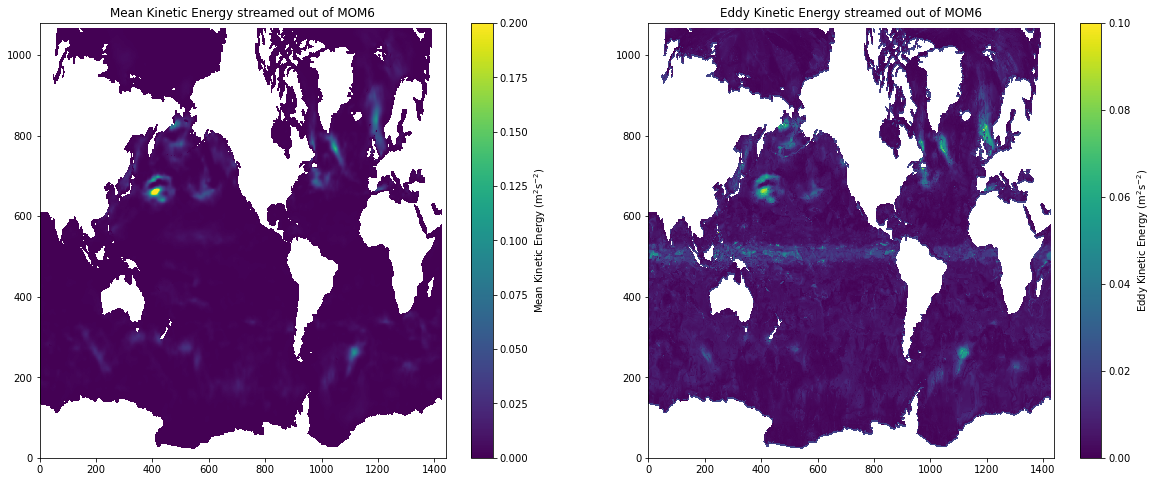

14:59:19 horizon SmartSim[11971] INFO mom6_model(707111.0): Completed


In [12]:
grid = xr.open_dataset('/home/users/ashao/lustre/dev/poseidon-smartsim/examples/MOM6/ml_eke/year1/mom6_model/sea_ice_geometry.nc')

plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
mke = reconstruct.reconstruct_domain(client, "MKE_59918400900.",3551).transpose()
mke[grid.wet==0] = np.nan
plt.pcolormesh(mke,vmin=0,vmax=.2)
plt.colorbar(label='Mean Kinetic Energy (m$^2$s$^{-2}$)')
plt.title("Mean Kinetic Energy streamed out of MOM6")

plt.subplot(1,2,2)
mke = reconstruct.reconstruct_domain(client,"EKE_59918400900.",3551).transpose()
mke[grid.wet==0] = np.nan
plt.pcolormesh(mke,vmin=0,vmax=.1)
plt.colorbar(label='Eddy Kinetic Energy (m$^2$s$^{-2}$)')
plt.title("Eddy Kinetic Energy streamed out of MOM6")

Text(0.5, 1.0, 'Eddy Kinetic Energy streamed out of MOM6')

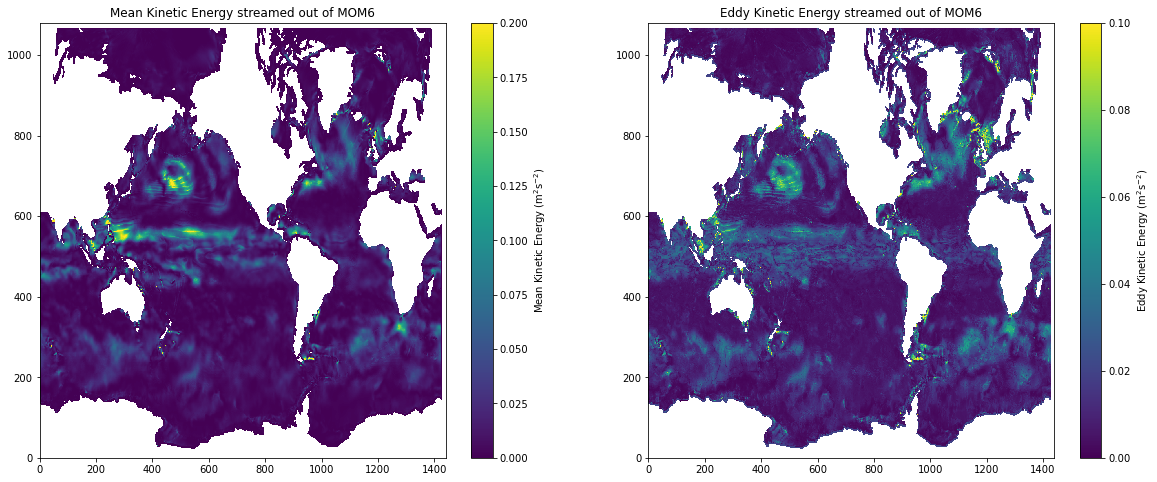

In [13]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
mke = reconstruct.reconstruct_domain(client,"MKE_59918479200.",3551).transpose()
mke[grid.wet==0] = np.nan
plt.pcolormesh(mke,vmin=0,vmax=.2)
plt.colorbar(label='Mean Kinetic Energy (m$^2$s$^{-2}$)')
plt.title("Mean Kinetic Energy streamed out of MOM6")

plt.subplot(1,2,2)
mke = reconstruct.reconstruct_domain(client,"EKE_59918479200.",3551).transpose()
mke[grid.wet==0] = np.nan
plt.pcolormesh(mke,vmin=0,vmax=.1)
plt.colorbar(label='Eddy Kinetic Energy (m$^2$s$^{-2}$)')
plt.title("Eddy Kinetic Energy streamed out of MOM6")

Text(0.5, 1.0, 'Eddy Kinetic Energy streamed out of MOM6')

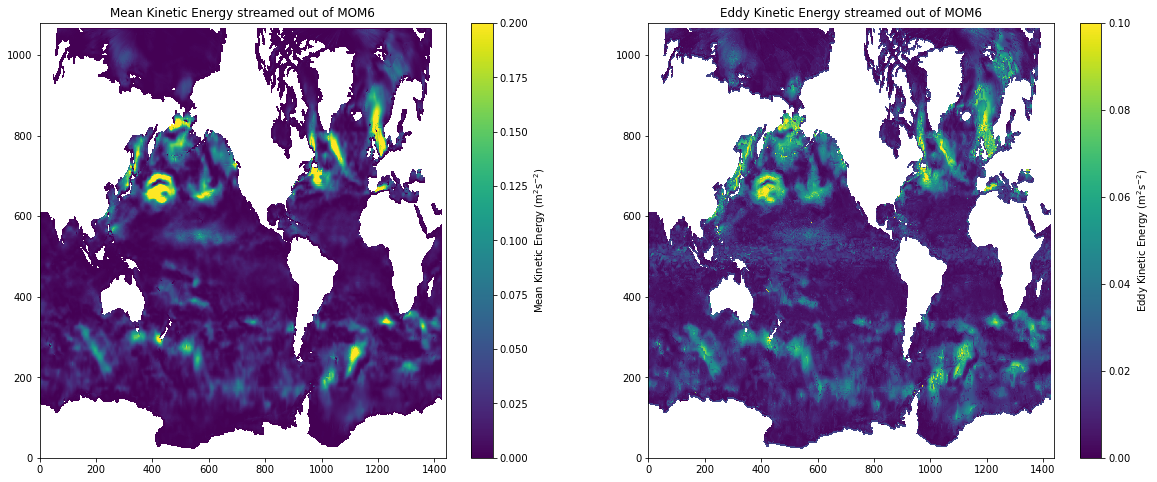

In [14]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
mke = reconstruct.reconstruct_domain(client,"MKE_59918408100.",3551).transpose()
mke[grid.wet==0] = np.nan
plt.pcolormesh(mke,vmin=0,vmax=.2)
plt.colorbar(label='Mean Kinetic Energy (m$^2$s$^{-2}$)')
plt.title("Mean Kinetic Energy streamed out of MOM6")

plt.subplot(1,2,2)
mke = reconstruct.reconstruct_domain(client,"EKE_59918408100.",3551).transpose()
mke[grid.wet==0] = np.nan
plt.pcolormesh(mke,vmin=0,vmax=.1)
plt.colorbar(label='Eddy Kinetic Energy (m$^2$s$^{-2}$)')
plt.title("Eddy Kinetic Energy streamed out of MOM6")

## 2.3) Release Computational Resources for the SmartSim Experiment

In [15]:
# stop the database
experiment.stop(orc)

# Release our system compute allocation for MOM6 and the database
slurm.release_slurm_allocation(db_alloc)
slurm.release_slurm_allocation(mom6_alloc)

15:01:01 horizon SmartSim[11971] INFO Stopping model orchestrator_0 job 707112.0
15:01:01 horizon SmartSim[11971] INFO Successfully stopped job 707112.0
15:01:01 horizon SmartSim[11971] INFO Stopping model orchestrator_1 job 707112.1
15:01:01 horizon SmartSim[11971] INFO Successfully stopped job 707112.1
15:01:01 horizon SmartSim[11971] INFO Stopping model orchestrator_2 job 707112.2
15:01:01 horizon SmartSim[11971] INFO Successfully stopped job 707112.2
15:01:01 horizon SmartSim[11971] INFO Stopping model orchestrator_3 job 707112.3
15:01:01 horizon SmartSim[11971] INFO Successfully stopped job 707112.3
15:01:01 horizon SmartSim[11971] INFO Stopping model orchestrator_4 job 707112.4
15:01:01 horizon SmartSim[11971] INFO Successfully stopped job 707112.4
15:01:01 horizon SmartSim[11971] INFO Stopping model orchestrator_5 job 707112.5
15:01:01 horizon SmartSim[11971] INFO Successfully stopped job 707112.5
15:01:01 horizon SmartSim[11971] INFO Stopping model orchestrator_6 job 707112.6
1